# Import

In [3]:
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math
import datetime
from scipy.spatial import cKDTree as kdtree
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.models import model_from_json
import pandas as pd
from plotnine import *
from jupyterplot import ProgressPlot
#from keras.callbacks import TensorBoard

import tensorflow as tf
import keras.backend.tensorflow_backend as backend
from threading import Thread
from tqdm import tqdm_notebook as tqdm

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla
print('IMPORT DONE')

Using TensorFlow backend.


IMPORT DONE


# Car Environment [Action/Reward here]

In [4]:
class CarEnv:
    global town
    #BRAKE_AMT = 1.0
    actor_list = []
    collision_hist = []
    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)
        world = self.client.load_world(town)
        self.world = self.client.get_world()
        blueprint_library = self.world.get_blueprint_library()
        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        self.place=0
        
        spectator = self.world.get_spectator()
        spectator.set_transform(carla.Transform(carla.Location(249,-120,3), carla.Rotation(yaw=-90)))
        
        #spawn a vehicle
        blueprint_library = self.world.get_blueprint_library()
        self.Isetta = blueprint_library.filter('Isetta')[0]
        
        
    def Black_screen(self):
        settings = self.world.get_settings()
        settings.no_rendering_mode = True
        self.world.apply_settings(settings)
    
    def set_location(self,x,y):
        
        self.lo_x,self.lo_y=x,y
        self.place=x,y
        
    def get_distance(self):
        l=self.vehicle.get_location()
        current_location=[l.x,l.y]
        dist,indice=kd_tree_map.query(current_location,1)
        return dist
    def get_location(self):
        l=self.vehicle.get_location()
        current_location=[l.x,l.y]
        return current_location
                     
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        
        ##print('Location: ',str(place))
        #transform = carla.Transform(carla.Location(-120,place,3),carla.Rotation(0,-90,0))
        if self.place == 0:
            transform = carla.Transform(carla.Location(249,-130,0.1),carla.Rotation(0,-90,0)) 
        else :
            transform = carla.Transform(carla.Location(self.lo_x,self.lo_y),carla.Rotation(0,-90,0))  
            
        self.flag = 0
        self.vehicle = self.world.spawn_actor(self.Isetta, transform)
        self.flag = 1
        
        self.actor_list.append(self.vehicle)
     

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')
        
        transform = carla.Transform(carla.Location(x=0, z=1.9))
        time.sleep(0.01)

        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)
     
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0))
        self.episode_start = time.time()
   
        time.sleep(0.4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle_f is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0))
        ref_map=self.get_distance()
        ##SENSOR LIDAR
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz,ref_map])
        
        return state_

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        
        lidar_f = lidar_line(points,90,2)
        lidar_r = lidar_line(points,45,2)
        lidar_l = lidar_line(points,135,2)

        if len(lidar_f) == 0:
            pass
        else:
            self.distance_to_obstacle_f = min(lidar_f[:,1])-2.247148275375366
        
        if len(lidar_r) == 0:
            pass
        else:
            self.distance_to_obstacle_r = np.sqrt(min(lidar_r[:,0]**2 + lidar_r[:,1]**2))
        
        if len(lidar_l) == 0:
            pass
        else:
            self.distance_to_obstacle_l = np.sqrt(min(lidar_l[:,0]**2 + lidar_l[:,1]**2))
    

    def step(self, action):
        global sleepy,steer_
        
        ref_map=self.get_distance()
        
        set_reward=3-ref_map
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0))
            time.sleep(sleepy)
            steer_+=0
            reward = set_reward
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.1))
            time.sleep(sleepy)
            steer_+=0.1
            reward = set_reward
        elif action == 2:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.1))
            time.sleep(sleepy)
            steer_+=-0.1
            reward = set_reward
        elif action == 3:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.3))
            time.sleep(sleepy)
            steer_+=0.3
            reward = set_reward
        elif action == 4:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.3))
            time.sleep(sleepy)
            steer_+=-0.3
            reward = set_reward
 

        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
            
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz,ref_map])
            
        return state_, reward, done, None
    
    def test_step(self,steer,sleepy):
        ref_map=self.get_distance()
        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = steer))
        time.sleep(sleepy)
        reward = 1
        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz,ref_map])
            
        return state_, reward, done, None
        

# Optional Function

In [5]:
def open_carla(require):
    try:
        if require == 'fast':
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe -benchmark  -fps=10 -quality-level=Low')
        else:
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe')
    except Exception as err:
        print(err)
    print('opening Carla')
    
def close_carla():
    try:
        os.system('TASKKILL /F /IM CarlaUE4.exe')
    except Exception as err:
        print(err)
    time.sleep(0.5)
    
def carla_is_running():
    import psutil    
    if "CarlaUE4.exe" in (p.name() for p in psutil.process_iter()):
        return True
    
def xxx():
    env.world.wait_for_tick()
    for x in list(env.world.get_actors()):
        if x.type_id == 'vehicle.tesla.model3' or x.type_id == 'sensor.lidar.ray_cast' or x.type_id == 'sensor.other.collision':
            x.destroy()
            
def lidar_line(points,degree,width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1.75, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

map=pd.read_csv('DATA\map_straight.csv')
kd_tree_map=kdtree(map.values)

# DQN Algorithm

In [6]:
class DQNAgent:
    
    def __init__(self,state_size,action_size):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     
        

    def create_model(self):
        
        model = Sequential()
        model.add(Dense(4, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, input_dim=4, activation='relu')) 
        model.add(Dense(self.action_size, activation='sigmoid'))            # output nodes = #action
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

In [7]:
class DQNAgent_load_model:
    
    def __init__(self,state_size,action_size,model):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.loaded_model(model)
        self.target_model = self.loaded_model(model)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
        
    def loaded_model(self,model):
        
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

# Input

In [8]:
SECONDS_PER_EPISODE = 100
REPLAY_MEMORY_SIZE = 5_000
MIN_REPLAY_MEMORY_SIZE = 32
MINIBATCH_SIZE = 32
PREDICTION_BATCH_SIZE = 1
TRAINING_BATCH_SIZE = MINIBATCH_SIZE // 4
UPDATE_TARGET_EVERY = 5


MEMORY_FRACTION = 0.4
MIN_REWARD = -200

EPISODES = 32000

DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = 0.99975 ## 0.9975 99975
MIN_EPSILON = 0.001

AGGREGATE_STATS_EVERY = 10
state_size=4
action_size=5

# NEW model or LOAD model

In [7]:
def load_model(model_name):
    json_file = open('DATA\\{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("DATA\\{}.h5".format(model_name))
    
    print("Loaded model from disk")
    loaded_model.summary()
    
    file_path="DATA\\"
    df=pd.read_csv(file_path+'{}.csv'.format(model_name))
    episode = df.Episode.tail(1).values[0]+1
    epsilon = df.Epsilon.tail(1).values[0]
    print('Episode : {} , Epsilon : {} '.format(episode,epsilon))
    
    return df,episode,epsilon,loaded_model
    

In [8]:
def save_every_5k(name,n):
    file_path="DATA\\"
    df.to_csv(file_path+'{}_{}.csv'.format(name,n))
    agent.save_model(file_path+name+'_'+str(n))

In [9]:
LOAD = True
model_name='backup\Steer_Full_2_040520_2130'
if LOAD == True :
    df_load,load_episode,load_epsilon,loaded_model = load_model(model_name)
    value=['Episode','Reward','avg_reward','Step','Loss','avg_loss','Steer','Explore','PCT_Explore','Epsilon']
    df_load=df_load[value]
    df_load

Loaded model from disk
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________
Episode : 29996 , Epsilon : 0.02597120386405621 


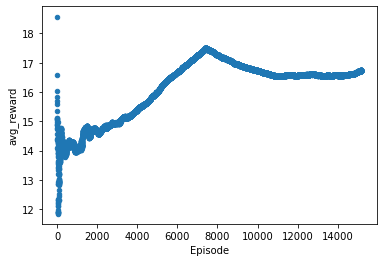

In [15]:
df_load.plot.scatter('Episode','avg_reward')

# MAIN

In [49]:
if __name__ == '__main__':
    
    
    if carla_is_running():
        pass
    else:
        close_carla()
        open_carla('fast')
        time.sleep(17)
    #open_carla('fast')
    FPS=60
    town='town03'
    ep_rewards = []
    ep=[]
    avg=0
    av_loss=0
    avg_loss=[]
    avg_reward=[]
    Step=[]
    Loss=[]
    Explore=[]
    Steer=[]
    Epsilon=[]
    random.seed(1)
    np.random.seed(1)
    steer_amt=0.3
    sleepy=0.3

    #pp = ProgressPlot(x_label="Episode",line_names=['Average_reward'])
    
    if LOAD == True:
    # In case Train from loaded_model
        agent=DQNAgent_load_model(state_size,action_size,loaded_model)
        epsilon=load_epsilon
        nn=0
        for i in df_load.Reward:
            avg=((avg*(nn)+i)/(nn+1))
            #pp.update(float(avg))
            nn+=1
        avg=sum(df_load.Reward)/df_load.shape[0]
        av_loss=sum(df_load.Loss)/df_load.shape[0]
    else :
        
    # Create agent and environment
        agent = DQNAgent(state_size,action_size)
        load_episode=0
    
    env = CarEnv()
    #env.Black_screen()
    xxx()
    
    agent.train_in_loop()
    agent.get_qs(np.ones((1, state_size)))
    
    ## Re_epsilon
    epsilon = 0.1

    # Iterate over episodes
    with tqdm(total=EPISODES-load_episode) as pbar:
        
        for episode in range(EPISODES-load_episode):            
            #try:

            env.collision_hist = []
            episode_reward = 0
            loss=0
            step = 1
            explore=0
            steer_=0

            # Reset environment and get initial state
            current_state = env.reset()

            # Reset flag and start iterating until episode ends
            done = False
            episode_start = time.time()

            # Play for given number of seconds only
            while True:

                # This part stays mostly the same, the change is to query a model for Q values
                rand=np.random.random()
                if rand > epsilon:
                    # Get action from Q table
                    action = np.argmax(agent.get_qs(current_state))
                    #action=loaded_model.predict(state)
                    #a=agent.get_qs(current_state)
                    
                    #a1=a[0]/a.sum()
                    #a2=a[1]/a.sum()            
                    #steer=(-steer_amt*a1)+(steer_amt*a2)
                    #new_state,reward,done,_= env.test_step(steer,sleepy)
                    
                    new_state, reward, done, _ = env.step(action)
                    #steer_+=steer
                    time.sleep(1/FPS)
                    
                else:
                    # Get random action
                    action = np.random.randint(0, action_size)
                    new_state, reward, done, _ = env.step(action)
                    explore+=1
                    
                    #if action==0:
                        #steer_+=steer_amt
                    #else :
                        #steer_-=steer_amt
                    
            
                    # This takes no time, so we add a delay matching 60 FPS (prediction above takes longer)
                    time.sleep(1/FPS)
             
                # Every step we update replay memory
                episode_reward += reward
              
            agent.update_replay_memory((current_state, action, reward, new_state, done))
                current_state = new_state
                step += 1

                if done:
                    break
                    
            # End of episode - destroy agents
            for actor in env.actor_list:
                actor.destroy()
            agent.train()
            
            # Decay epsilon
            if epsilon > MIN_EPSILON:
                epsilon *= EPSILON_DECAY
                epsilon = max(MIN_EPSILON, epsilon)
                
            print('Episode :{}, Step :{}, Epsilon :{} ,Reward :{}, Explore_rate :{}, loss :{} ,Steer :{}'\
                  .format(episode+load_episode,step,epsilon,episode_reward,explore/step,Loss[episode],steer_/step))
            
            ep_rewards.append(episode_reward)
            ep.append(episode+load_episode)
            Step.append(step)
            Explore.append(explore)
            Steer.append(steer_/step)
            Epsilon.append(epsilon)
            avg=((avg*(episode+load_episode)+episode_reward)/(episode+load_episode+1))
            avg_reward.append(avg)
            av_loss=((av_loss*(episode+load_episode)+Loss[episode])/(episode+load_episode+1))
            avg_loss.append(av_loss)
            #pp.update(float(avg))  
            
            if (episode+load_episode) %5000 ==0 :
                df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,\
                 'avg_reward':avg_reward,'Step':Step,'Loss':Loss[1:],\
                 'avg_loss':avg_loss,\
                'Steer':Steer,'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100\
                ,'Epsilon':Epsilon})
                if LOAD == True:
                    df=pd.concat([df_load,df],ignore_index=True)
                save_every_5k(model_name,episode+load_episode)
            
            
            #pbar.update(1)
    close_carla()
    pp.finalize()
   

IndentationError: unexpected indent (<ipython-input-49-4a5cca929b63>, line 117)

# Graph

In [ ]:
df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,\
                 'avg_reward':avg_reward,'Step':Step,'Loss':Loss[1:],\
                 'avg_loss':avg_loss,\
                'Steer':Steer,'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100\
                ,'Epsilon':Epsilon})
if LOAD == True:
    df=pd.concat([df_load,df],ignore_index=True)
df

In [18]:
df=pd.read_csv('DATA\Steer_Full_2.csv')

In [19]:
df.describe()

,Unnamed: 0,Episode,Reward,avg_reward,Step,Loss,avg_loss,Steer,Explore,PCT_Explore,Epsilon
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,3.000100e+04,30001.000000,30001.000000,19073.000000
mean,15000.000000,15000.000000,18.195860,17.061962,13.321489,1.200820,1.175494,-5.654478e-03,3.312223,25.195250,0.220365
std,8660.687049,8660.687049,17.740315,1.238783,4.682422,1.785551,0.057320,3.812292e-02,3.071972,21.750168,0.160314
min,0.000000,0.000000,-1676.656083,11.848364,5.000000,0.000000,0.000000,-2.000000e-01,0.000000,0.000000,0.025939
25%,7500.000000,7500.000000,14.687718,16.567915,10.000000,0.799165,1.136241,-2.857143e-02,1.000000,8.333333,0.060199
50%,15000.000000,15000.000000,18.041808,17.096202,12.000000,0.889446,1.165085,-2.921640e-18,3.000000,20.000000,0.183503
75%,22500.000000,22500.000000,22.950693,18.142784,15.000000,1.186469,1.204025,1.500000e-02,5.000000,38.461538,0.368271
max,30000.000000,30000.000000,74.708490,18.764352,64.000000,102.244302,1.326161,2.500000e-01,29.000000,95.833333,0.499875


C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 951 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


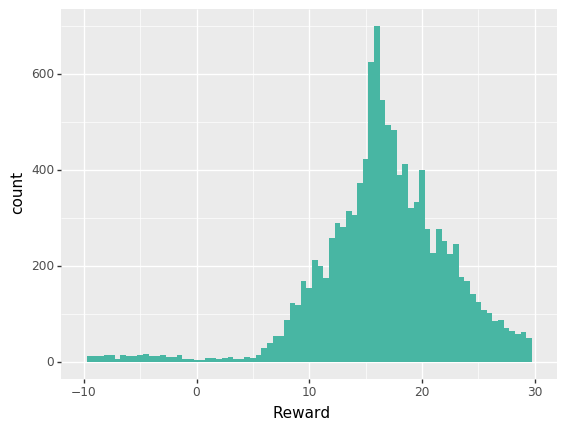

<ggplot: (-9223371905051876597)>

In [20]:
ggplot(df.iloc[:12500],aes(x='Reward'))+\
geom_histogram(binwidth=0.5,fill='#48b6a3')+\
xlim(-10,30)

In [100]:
df.iloc[12500]

Unnamed: 0     12500.000000
Episode        12500.000000
Reward            19.105552
avg_reward        16.584439
Step              14.000000
Loss               2.025247
avg_loss           1.118157
Steer             -0.028571
Explore            1.000000
PCT_Explore        7.142857
Epsilon            0.043909
reward/step        1.364682
Name: 12500, dtype: float64

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 401 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


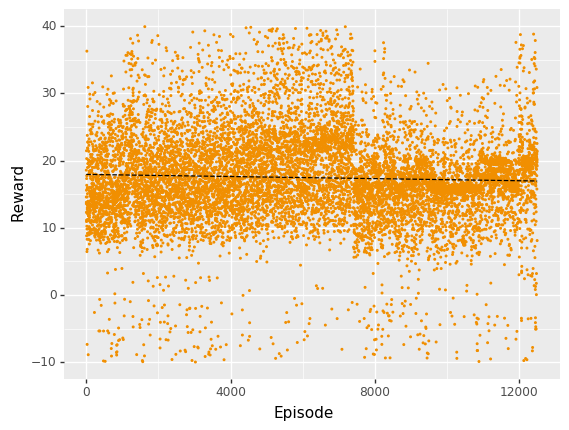

<ggplot: (131818851781)>

In [102]:
ggplot(df[:12500], aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(-10,40)

In [ ]:
ggplot(df, aes(x='Episode',y='Step'))+ \
    geom_line(size=0.05,alpha=0.8) +\
    stat_smooth(colour='blue', span=0.2)+\
        ylim(0,30)

In [21]:
n=0
c=0
xx=[]
yy=[]
for i in df['Reward']:
    n+=i
    c+=1
    if c%100==0:
        xx.append(n/100)
        n=0
n=0
c=0
for i in df['Step']:
    n+=i
    c+=1
    if c%100==0:
        yy.append(n/100)
        n=0


In [23]:
df[df['Reward']>20].describe()

,Unnamed: 0,Episode,Reward,avg_reward,Step,Loss,avg_loss,Steer,Explore,PCT_Explore,Epsilon,reward/step
count,11432.000000,11432.000000,11432.000000,11432.000000,11432.000000,11432.000000,11432.000000,11432.000000,11432.000000,11432.000000,8100.000000,11432.000000
mean,15664.333275,15664.333275,26.896098,17.184056,16.528954,1.218485,1.174641,-0.007666,4.252187,25.992189,0.260883,1.661173
std,8135.691427,8135.691427,6.572825,1.144918,4.554248,2.184382,0.052533,0.025540,3.333843,19.534881,0.152689,0.263015
min,6.000000,6.000000,20.000405,12.237895,10.000000,0.000000,0.595659,-0.140000,0.000000,0.000000,0.025939,0.633856
25%,7366.500000,7366.500000,22.048949,16.585172,13.000000,0.804845,1.127052,-0.023529,2.000000,9.523810,0.116708,1.493506
50%,17123.500000,17123.500000,25.053527,17.314648,15.000000,0.893740,1.167592,-0.006667,4.000000,23.431373,0.284480,1.661509
75%,21346.250000,21346.250000,29.666555,18.125485,18.000000,1.140893,1.200270,0.008333,6.000000,38.461538,0.393204,1.851884
max,30000.000000,30000.000000,74.708490,18.764352,46.000000,102.244302,1.325622,0.100000,29.000000,95.833333,0.499875,2.360114


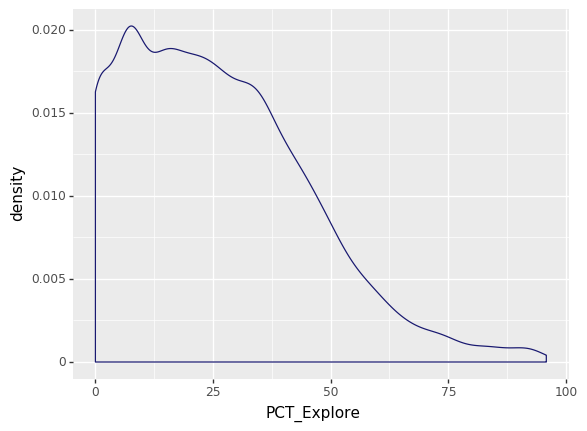

<ggplot: (-9223371905051831927)>

In [24]:
ggplot(df[df['Reward']>20])+\
geom_density(aes(x='PCT_Explore'),color='midnightblue')

In [25]:
df__=pd.DataFrame({'reward':xx,'avg_every_100ep':[i for i in range(len(xx))],'step':yy})

In [26]:
df__['reward/step']=df__['reward']/df__['step']

In [116]:
df.columns

Index(['Unnamed: 0', 'Episode', 'Reward', 'avg_reward', 'Step', 'Loss',
       'avg_loss', 'Steer', 'Explore', 'PCT_Explore', 'Epsilon',
       'reward/step'],
      dtype='object')

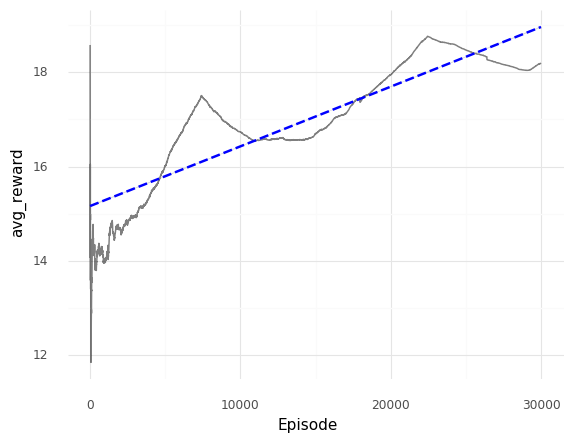

<ggplot: (-9223371905029346258)>

In [123]:
ggplot(df, aes(x='Episode',y='avg_reward'))+ \
    geom_line(size=0.6,alpha=0.5) +\
    stat_smooth(colour='blue', span=0.2,linetype='dashed')+\
    theme_minimal()

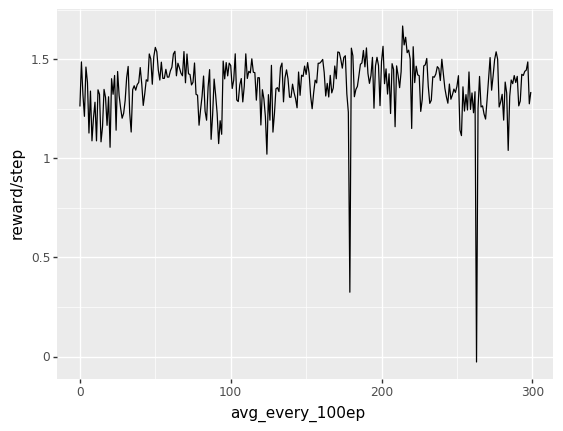

<ggplot: (131802883413)>

In [28]:
ggplot(df__)+\
geom_line(aes(y='reward/step',x='avg_every_100ep'))

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


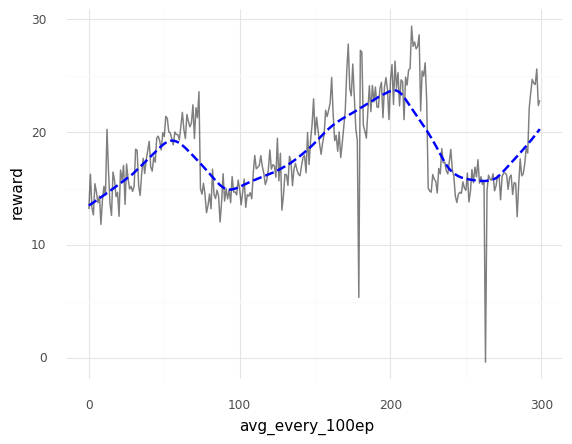

<ggplot: (-9223371905029180735)>

In [122]:
ggplot(df__, aes(x='avg_every_100ep',y='reward'))+ \
    geom_line(size=0.6,alpha=0.5) +\
    stat_smooth(colour='blue', span=0.2,linetype='dashed')+\
theme_minimal()

In [ ]:
ggplot(df, aes(x='Episode',y='avg_reward'))+ \
    geom_line(size=0.7,color='seagreen') +\
    stat_smooth(colour='blue', span=0.3,size=0.4)

In [ ]:
ggplot(df, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(0,30)

In [ ]:
ggplot(df.iloc[10000:], aes(x='Episode',y='Steer'))+ \
  geom_point(color="#F18F01", size=0.2) +\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")

In [ ]:
ggplot(df, aes(x='Episode',y='Loss'))+ \
  geom_line(size=0.01,color='mediumblue') +\
    geom_smooth(method="lm",color='firebrick', se=False, size=0.5, linetype="dashed")+\
ylim(0,3)

In [ ]:
ggplot(df, aes(x='Episode',y='avg_loss'))+ \
  geom_point(color='midnightblue',size=0.05) +\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")

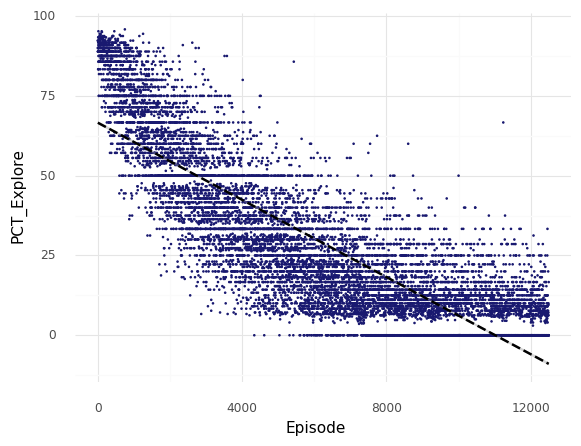

<ggplot: (131804248945)>

In [121]:
ggplot(df.iloc[:12500], aes(x='Episode',y='PCT_Explore'))+ \
  geom_point(color='midnightblue',size=0.05) +\
    geom_smooth( size=1, linetype="dashed")+\
theme_minimal()

# Save data and model

In [ ]:
name='Steer_Full_2' ##INSERT FILE NAME
n = datetime.datetime.now()
n = n.strftime('_%m%d%y_%H%M')

##real
file_path="DATA\\"
df.to_csv(file_path+'{}.csv'.format(name))
agent.save_model(file_path+name)
##backup
name=name+n
file_path_backup="DATA\\backup\\"
df.to_csv(file_path_backup+'{}.csv'.format(name))
agent.save_model(file_path_backup+name)

# Load model for Test

In [9]:
model_name='backup\Steer_Full_2_040520_2130'

json_file = open('DATA\\{}.json'.format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("DATA\\{}.h5".format(model_name))
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


# Test model 

In [10]:
if carla_is_running():
    print('carla is running')
else:
    close_carla()
    open_carla('not fast')
    time.sleep(17)

town='town03'
test_ep=10
test_step=[]
test_reward=[]
test_action=[]
test_steer=[]
steer_amt=0.3
env=CarEnv()
sleepy=0.1
map_save=[]
dist_average=[]
dist=[]
time_=[]
finish=[]
state_size=loaded_model.input.shape[1]
action_size=loaded_model.output.shape[1]
print('State size = {} // Action size = {} '.format(state_size,action_size))


with tqdm(total=test_ep) as pbar:
    for episode in range(test_ep):
        state=env.reset()
        map_=[]
        dist_=[]
        action_=[]
        done = False
        step=0
        rewards=0
        steer_=0
        
        while True:
            step+=1
            state=np.array([[i for i in state]])
            action=np.argmax(loaded_model.predict(state))
            map_.append(env.get_location())
            dist_.append(env.get_distance())
            action_.append(action)
            time.sleep(0.01)
            state,reward,done,_=env.step(action)
            rewards+=reward
            
    
            if done:
                finish.append(False)
                break
            #if step == 260:
                #print('SUCCESS')
                #finish.append(True)
                #break
            
        for actor in env.actor_list:
                actor.destroy()
                
        dist_average.append(np.sum(dist_)/len(dist_))
        map_save.append(map_)
        test_action.append(action_)
        test_reward.append(rewards)
        test_step.append(step)
        test_steer.append(steer_/step)
        
        pbar.update(1)
close_carla()

opening Carla
State size = 4 // Action size = 5 


KeyboardInterrupt: 

In [87]:
df_test=pd.DataFrame({'Episode':[i for i in range(len(test_step))],\
                      'Step':test_step,'Reward':test_reward,\
                    'Steer':test_steer,'Dist':dist_average,'Finish':finish})
df_test

,Episode,Step,Reward,Steer,Dist,Finish
0,0,260,502.979168,-0.021538,1.064240,True
1,1,260,489.285205,-0.019615,1.116968,True
2,2,260,516.613884,-0.019231,1.012583,True
3,3,260,502.025130,-0.019615,1.068604,True
4,4,260,455.870983,-0.019615,1.245994,True
5,5,260,488.810249,-0.020385,1.119757,True
6,6,260,487.934130,-0.018846,1.122555,True
7,7,260,504.856750,-0.020000,1.057770,True
8,8,260,509.838154,-0.018077,1.037674,True
9,9,260,516.069586,-0.019231,1.014546,True


In [89]:
df_test.mean()

Episode      4.500000
Step       260.000000
Reward     497.428324
Steer       -0.019615
Dist         1.086069
Finish       1.000000
dtype: float64

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 1140 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


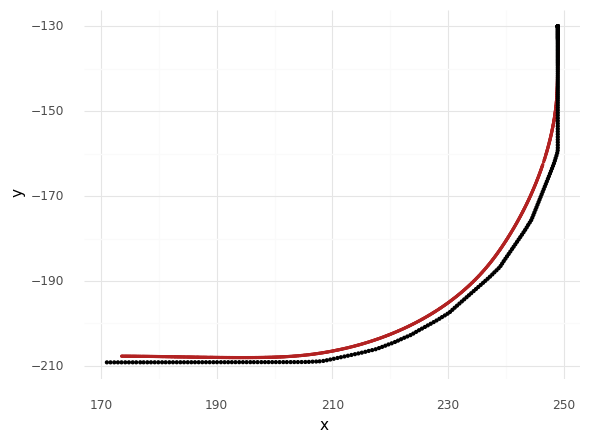

<ggplot: (149862545791)>

In [90]:
## MAP Observation
epi_test=5
map_create=pd.DataFrame({'X':np.array(map_save[epi_test])[:,0],'Y':np.array(map_save[epi_test])[:,1]})
mp=pd.concat([map.iloc[1:1400],map_create],axis=1)

##PLOT
ggplot(mp)+\
geom_point(aes(x='x',y='y'),size=0.3,color='firebrick')+\
geom_point(aes(x='X',y='Y'),size=0.7)+\
theme_minimal()

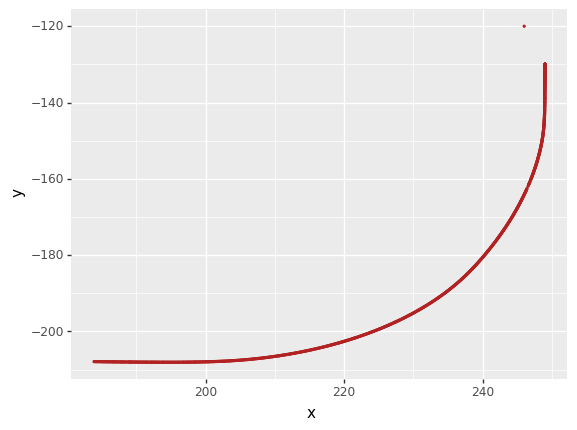

<ggplot: (-9223371886989081719)>

In [36]:
ggplot(map.iloc[:1300])+\
geom_point(aes(x='x',y='y'),size=0.3,color='firebrick')

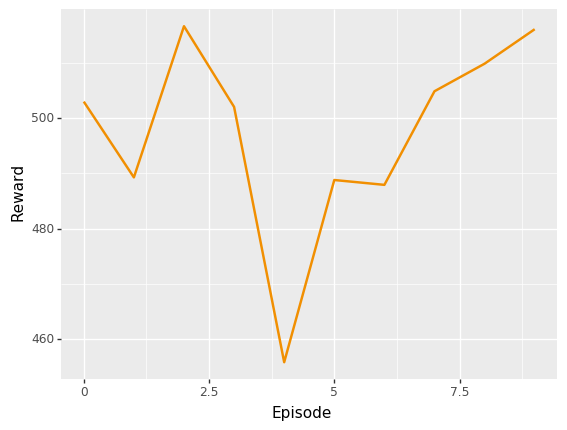

<ggplot: (-9223371886989466252)>

In [88]:
ggplot(df_test, aes(x='Episode',y='Reward'))+ \
  geom_line(color="#F18F01", size=1)

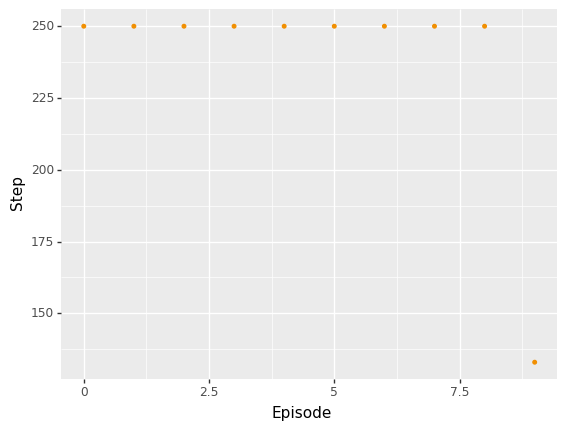

<ggplot: (149862572485)>

In [30]:
ggplot(df_test, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=1)

In [31]:
xxx()

RuntimeError: time-out of 10000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

In [ ]:
close_carla()